# Evaluate 

In [1]:
import matplotlib.pyplot as plt
import random
import torch
import os
import numpy as np
def dummy_npwarn_decorator_factory():
  def npwarn_decorator(x):
    return x
  return npwarn_decorator
np._no_nep50_warning = getattr(np, '_no_nep50_warning', dummy_npwarn_decorator_factory)

import seaborn as sns
from time import time



from utils.loss import LOSS_FN, LOSS_FN_H, LOSS_EVAL, LOSS_EVAL_H, absolute_val_error, squared_val_error
from utils.model import SegDataset, UNet
from utils.utils import load_model, read_raster, read_raster_multi
from utils.embedding import embed_token_raster, load_embedding

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'


In [2]:
# evaluate on cpu 
device = "cpu"

# # Zurich data
# train_images = ["./data/zurich_mask.tif", "./data/zurich.tif", "./data/zurich_terrain.tif"] # SVF input
# mask_images  = ["./data/zurich_svf_masked.tif"]                                             # SVF output
# trainH_images = ["./data/zurich_mask.tif", "./data/zurich_osm.tif"]                            # Height model input
# maskH_images  = ["./data/zurich.tif"]                                                       # Height model output
# clipping=False # no clipping for 

# Singapore data
train_images = ["./data/sg_mask.tif", "./data/sg.tif", "./data/sg_terrain.tif"] # SVF input
mask_images  = ["./data/sg_svf_masked.tif"]                                     # SVF output
trainH_images = ["./data/sg_mask.tif", "./data/sg_osm.tif"]                     # Height model input
maskH_images  = ["./data/sg.tif"]                                               # Height model output
clipping=True  # clipping out parts of Singapore data that have sea areas (to evaluate land only, no land-sea terrain transition)

# read in the input/output rasters for the SVF model
train_rasters = []
mask_rasters  = []
for file in train_images:
    data, _, _, _ = read_raster(file)
    if file.endswith('_terrain.tif'):
        minval = np.min(data)
        data = data - minval
        print(data.shape)
    if (clipping): data = data[0:4000, 0:6000]
    train_rasters.append(torch.tensor(data, device=device, dtype=torch.float32))
for file in mask_images:
    data, _, _, _ = read_raster(file)
    if (clipping): data = data[0:4000, 0:6000]
    mask_rasters.append(torch.tensor(data, device=device))
data_shape = data.shape
print(f'Data shape: {data_shape}')


# read in the input/output rasters for the height model
trainH_rasters = []
maskH_rasters  = []
for file in trainH_images:
    if file.endswith('img.tif') or file.endswith('osm.tif'):
        data_rasters, _, _, _ = read_raster_multi(file)
        for data in data_rasters:
            if (clipping): data = data[0:4000, 0:6000]
            trainH_rasters.append(torch.tensor(data, device=device, dtype=torch.float32))
    elif file.endswith('zones_tokens.tif'):
        data, _, _, _ = read_raster(file)
        emb2 = load_embedding("afs.bzo_zone_v.emb.pt", device="cpu")
        emb_map2 = embed_token_raster(data, emb2)          # [8, 512, 512]
        for data in emb_map2:
            if (clipping): data = data[0:4000, 0:6000]
            trainH_rasters.append(torch.tensor(data, device=device, dtype=torch.float32))
        print(emb_map2.shape)
    else:
        data, _, _, _ = read_raster(file)
        if (clipping): data = data[0:4000, 0:6000]
        trainH_rasters.append(torch.tensor(data, device=device, dtype=torch.float32))
for file in maskH_images:
    data, _, _, _ = read_raster(file)
    if (clipping): data = data[0:4000, 0:6000]
    maskH_rasters.append(torch.tensor(data, device=device, dtype=torch.float32))
data_shape = data.shape
print(f'Data shape: {data_shape}')


(6500, 11000)
Data shape: (4000, 6000)
Data shape: (4000, 6000)


In [3]:
model = None
prev_losses = None

def loadModel():
    global prev_losses
    filename = 'models/model_SVF.100.pth'
    current_epoch = 100
    MODEL_LOADED = None
    if filename is not None:
        loaded = load_model(filename, UNet, strict=True, load_ema=True, in_channels=len(train_rasters))
        model = loaded["model"].to(device)
        prev_losses = loaded["prev_losses"]
        print('Model loaded:', filename)
    return model, current_epoch, MODEL_LOADED

model, _,_ =loadModel()

Model loaded: models/model_SVF.100.pth


In [4]:

modelH = None
prev_losses_h = None


def loadModelH():
    global prev_losses_h
    filename = 'models/model_height.100.pth'
    current_epoch = 100
    MODEL_LOADED = None
    if filename is not None:
        loaded = load_model(filename, UNet, strict=True, load_ema=True, in_channels=len(trainH_rasters))
        model = loaded["model"].to(device)
        prev_losses_h = loaded["prev_losses"]
        print('Model loaded:', filename)
    return model, current_epoch, MODEL_LOADED

modelH, _,_ = loadModelH()


Model loaded: models/model_height.100.pth


0 / 4; [3269, 1678]


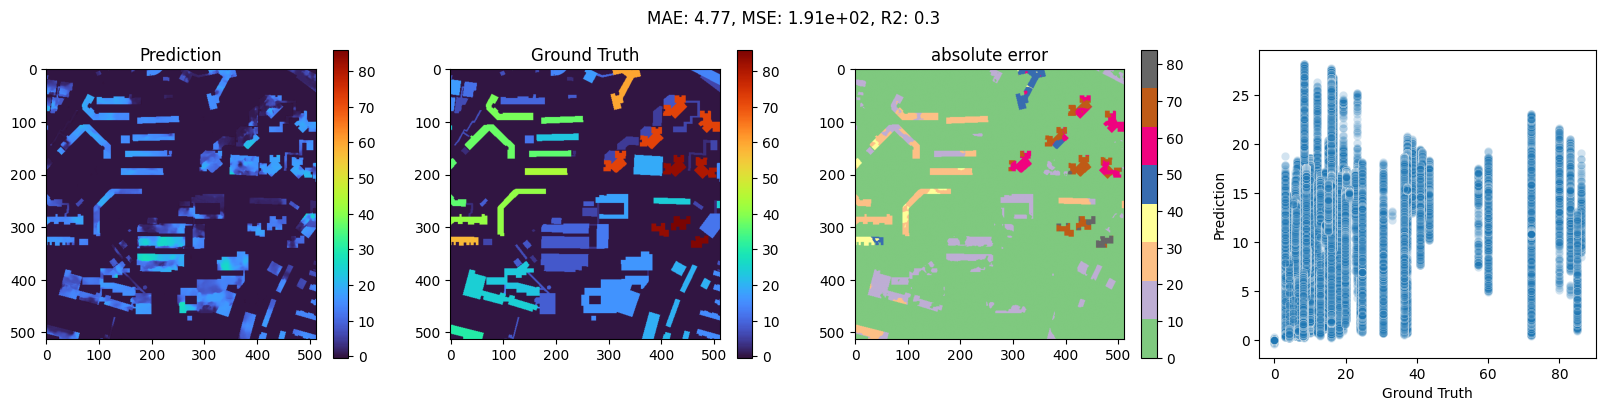

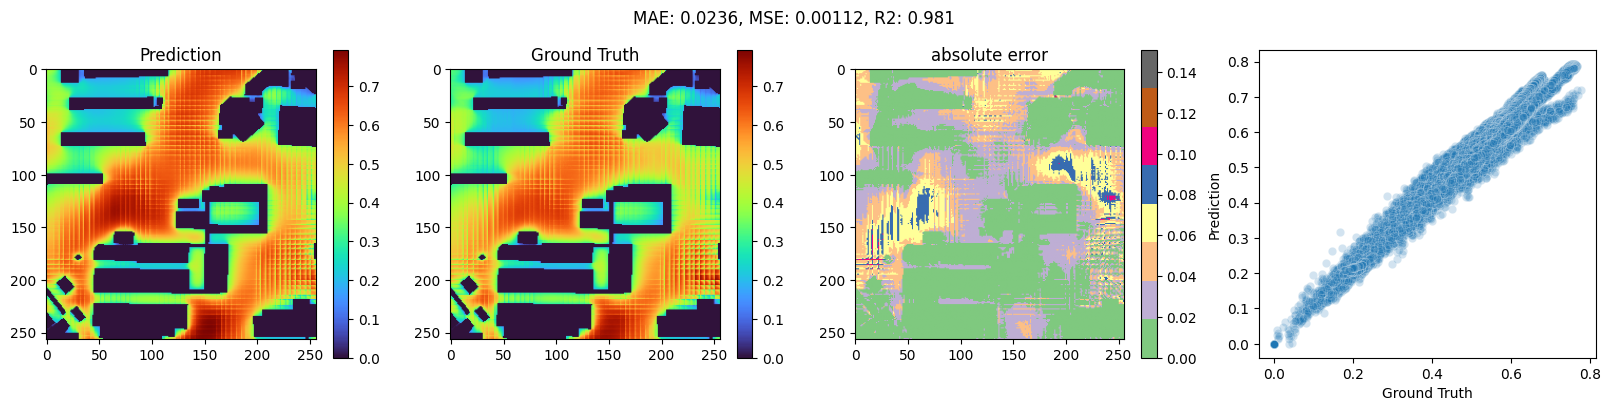

1 / 4; [2834, 1550]


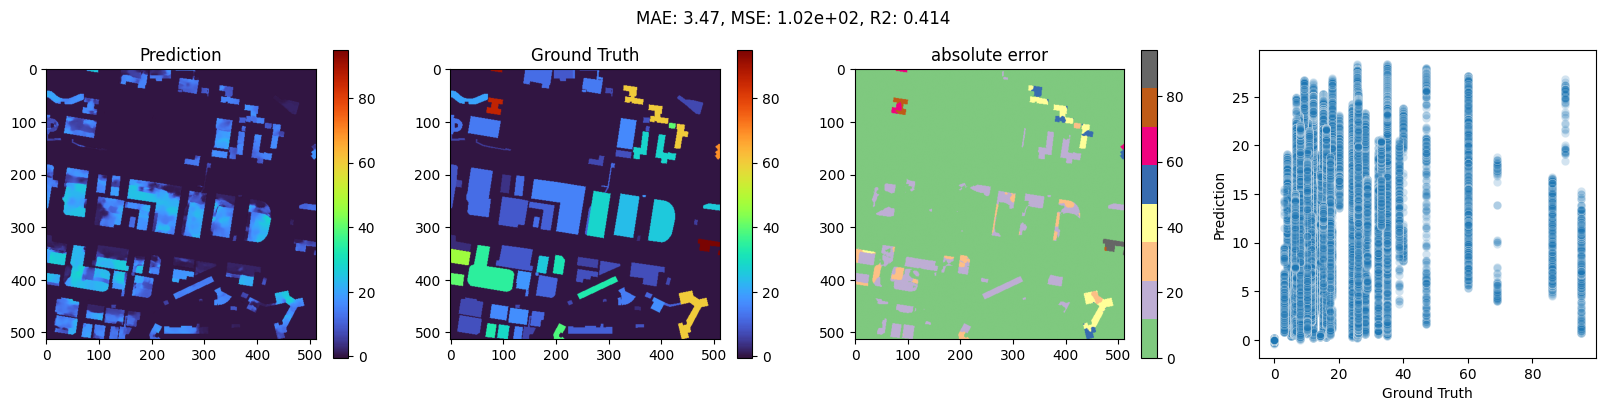

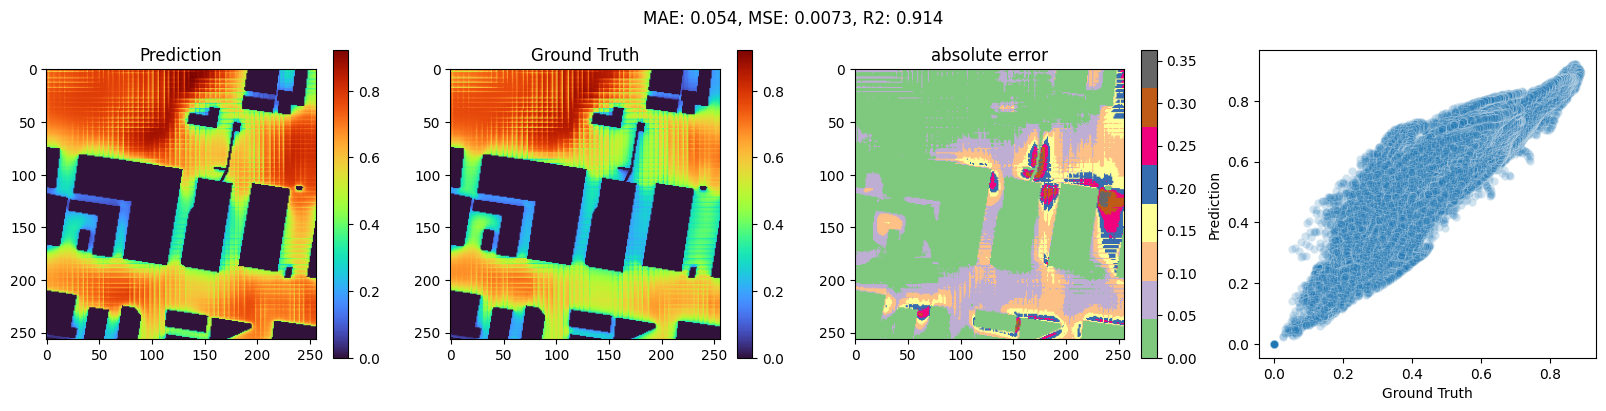

2 / 4; [1349, 3414]


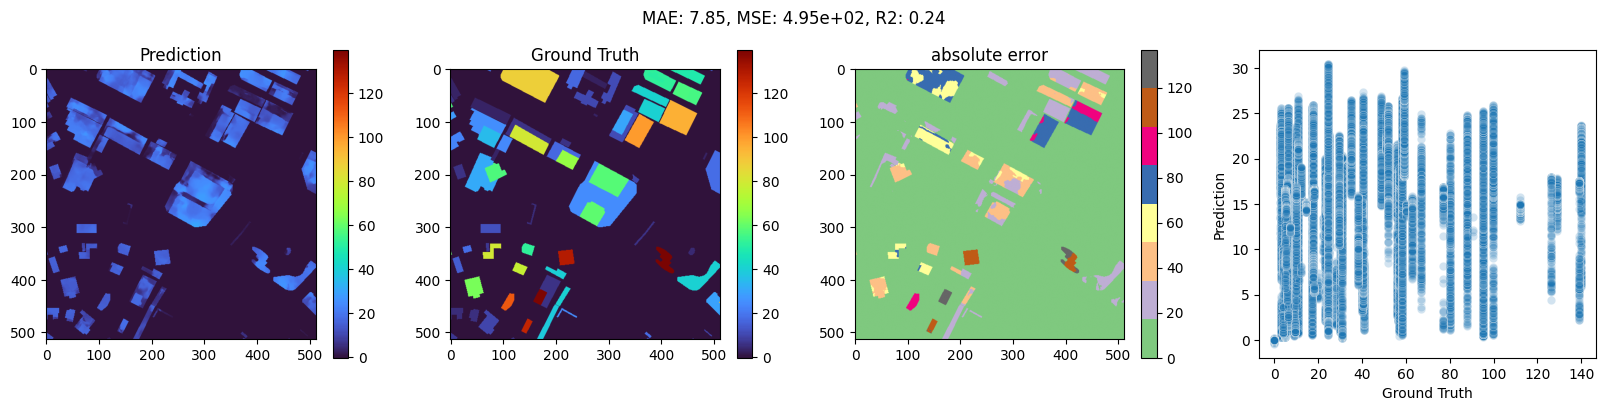

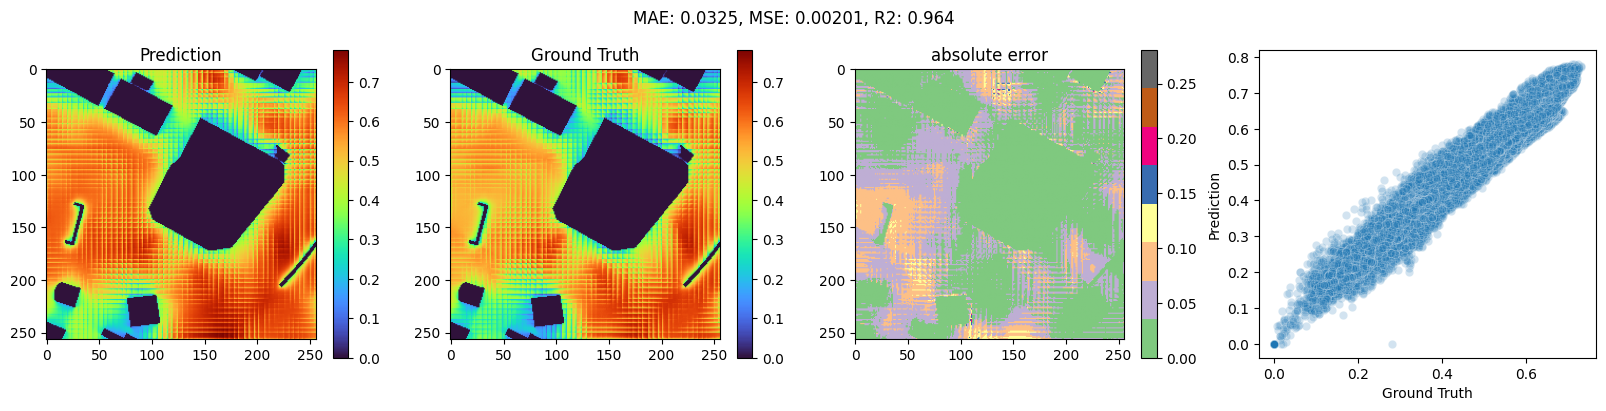

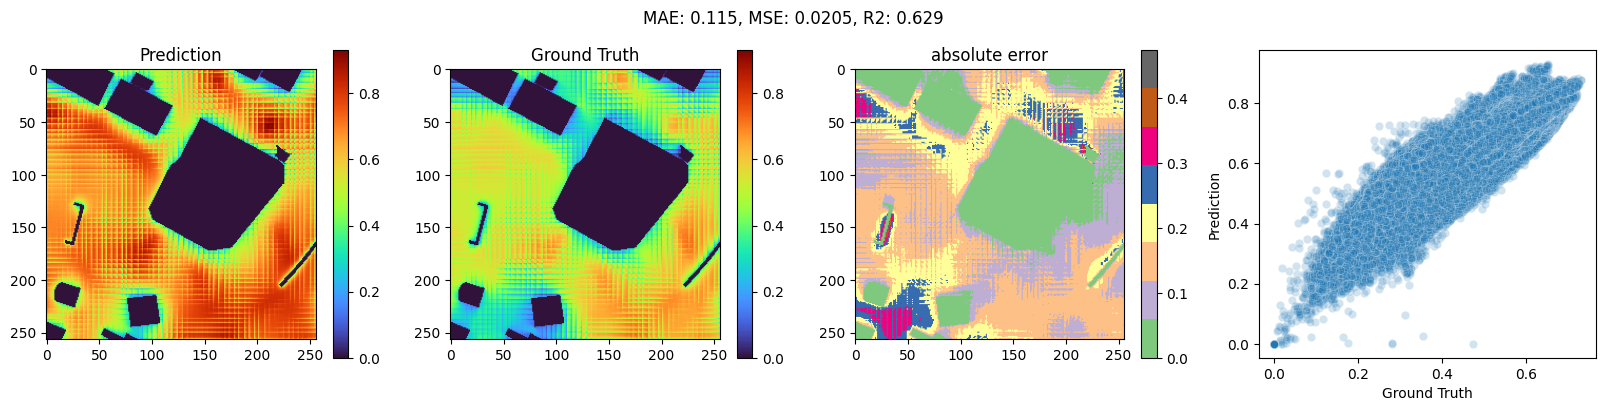

3 / 4; [363, 5442]


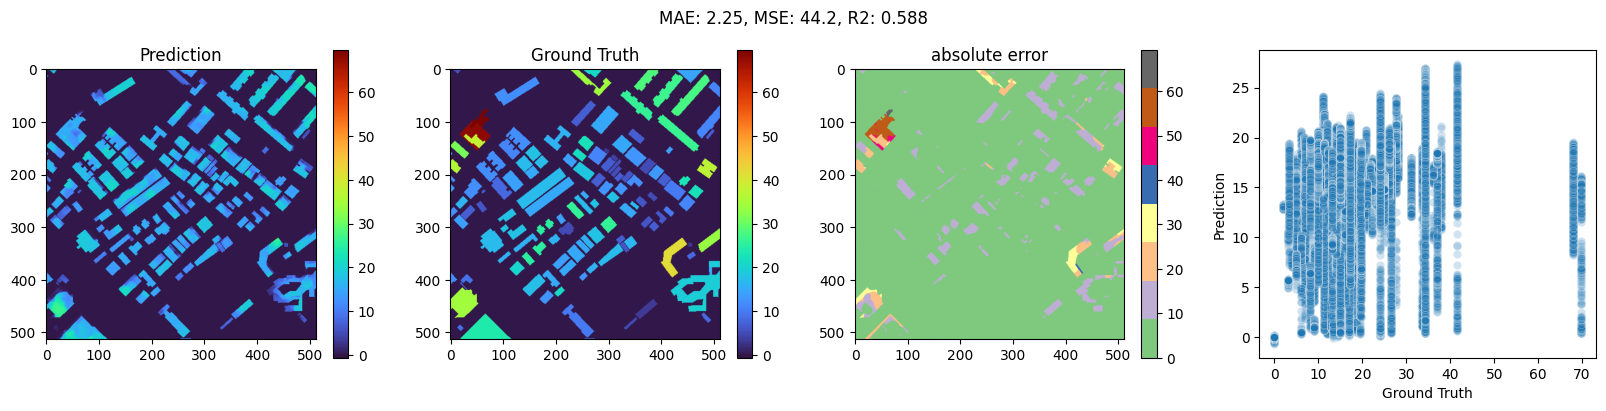

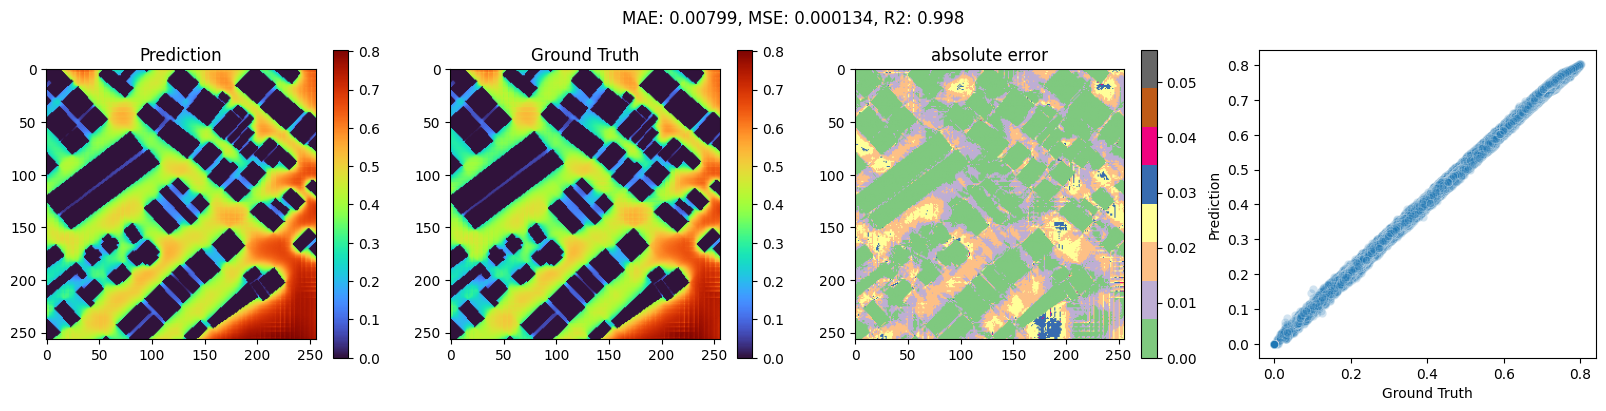

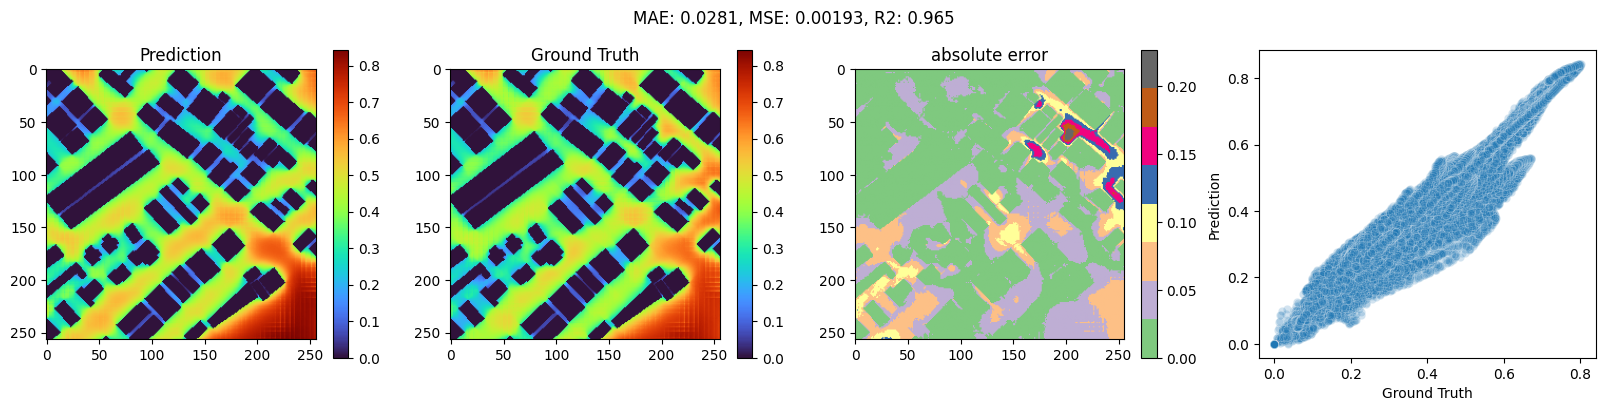

Time taken for 4 samples: 6.998118162155151 seconds


In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr, spearmanr
import pandas as pd

idx = []
datalen = 4
# datalen = 100
scan = 128
size = 512
footprint_raster = train_rasters[0]
while len(idx) < datalen:
    y, x = random.randint(0, data_shape[0] - 512 - 1), random.randint(0, data_shape[1] - 512 - 1)
    if footprint_raster[y : y+size, x : x+size].sum() > 1000:
        idx.append([y, x])
# idx = [[1153, 6974], [1268, 3354], [2941, 6939],[4876, 5998]]


dataset = SegDataset(train_rasters, mask_rasters, idx, size=512, offset=[0, 0], terrain_idx=-1)
datasetH = SegDataset(trainH_rasters, maskH_rasters, idx, size=512, offset=[0, 0], terrain_idx=None)
datasetP = SegDataset(trainH_rasters, maskH_rasters, idx, size=512, offset=[0, 0], terrain_idx=None)

EVAL_PARAMS = ['mae', 'mse', 'r2', 'pcc']
def setup_data():
    return [[],[]]

def predict_and_plot(imgs, masks, model_, loss_fn, data, is_height=False):
    model_.eval()
    with torch.no_grad():
        logits = model_(imgs)
        loss = loss_fn(logits, imgs, masks)

        # pred = (logits[j,0] * (1 - imgs[j,0])).clamp(0, 1).cpu().numpy() 
        pred = logits[0][0].cpu().numpy() 
        # pred = torch.sigmoid(logits[j,0]).cpu().numpy() 
        true = masks[0][0].cpu().numpy()
        m = imgs[0, 0].cpu().numpy()
        if not is_height:
            pred = pred[scan : -scan, scan : -scan]
            true = true[scan : -scan, scan : -scan]
            m = m[scan : -scan, scan : -scan]
        pred0 = pred.reshape(-1)
        true0 = true.reshape(-1)

        # if (np.min(pred) < -10) and not is_height: return logits[0][0] 
        data[0].append(true)
        data[1].append(pred)

        # if (np.min(pred) < -1) and not is_height: 
        #     pass
        # else: return logits[0][0]


        n = logits[0][0].numel()
        if n == 0: n = 1e-8
        mae = mean_absolute_error(true0, pred0)
        mse = mean_squared_error(true0, pred0)
        r2 = r2_score(true0, pred0)

        valmin = np.min([pred, true])
        valmax = np.max([pred, true])
        diff = np.abs(pred - true)
        diffmax = np.max(diff)


        val = [{
            'label': 'Prediction',
            'v': pred,
            "color": 'turbo',
            'vminmax': [valmin, valmax]
        }, { 
            'label': 'Ground Truth',
            'v': true,
            "color": 'turbo',
            'vminmax': [valmin, valmax]
        }, {
            # 'label': f'absolute error\nmax {percentile} percentile',
            'label': f'absolute error',
            'v': diff,
            "color": 'Accent',
            # 'vminmax': [0, np.min([0.05, diffmax])]
            'vminmax': [0, diffmax]
            # 'vminmax': [None, None]
        # }, {
        #     'label': 'mask',
        #     'v': img[0].cpu().numpy()[scan : -scan, scan : -scan],
        #     "color": None,
        #     # 'vminmax': [0, 0.2]
        #     'vminmax': [0, 1]
        }]
        if is_height:
            val = [{
                'label': 'Prediction',
                'v': pred,
                "color": 'turbo',
                'vminmax': [valmin, valmax]
            }, { 
                'label': 'Ground Truth',
                'v': true,
                "color": 'turbo',
                'vminmax': [valmin, valmax]
            }, {
                # 'label': f'absolute error\nmax {percentile} percentile',
                'label': f'absolute error',
                'v': diff,
                "color": 'Accent',
                'vminmax': [0, diffmax]
            }]

        fig, ax = plt.subplots(1, len(val) + 1)
        
        fig.set_figheight(4)
        fig.set_figwidth(20)
        fig.suptitle(f'MAE: {mae:.3}, MSE: {mse:.3}, R2: {r2:.3} ', fontsize=12)

        for i in range(len(val)):
            vmin, vmax = val[i]['vminmax']
            im = ax[i].imshow(val[i]['v'], val[i]['color'], vmin=vmin, vmax=vmax)
            ax[i].set_title(val[i]['label'])

            plt.colorbar(im)
        sns.scatterplot(data=pd.DataFrame({'Ground Truth': true0, 'Prediction': pred0}), x='Ground Truth', y='Prediction', ax=ax[-1], alpha=0.2)

        plt.show()

        # return None
        return logits[0][0]

dataH = setup_data()
data0  = setup_data()
data1 = setup_data()
starttime = time()
for j in range(datalen):
    imgsH = datasetH[j][0].unsqueeze(0).to(device)
    masksH = datasetH[j][1].unsqueeze(0).to(device)
    imgs = dataset[j][0].unsqueeze(0).to(device)
    masks = dataset[j][1].unsqueeze(0).to(device)
    imgs1 = imgs.clone()

    print(f'{j} / {datalen}; {idx[j]}')

    imgs1[0, 1] = predict_and_plot(imgsH, masksH, modelH, LOSS_FN_H, dataH, is_height=True)
    predict_and_plot(imgs, masks, model, LOSS_FN, data0)
    predict_and_plot(imgs1, masks, model, LOSS_FN, data1)

endtime = time()
print(f'Time taken for {datalen} samples: {endtime - starttime} seconds')



In [6]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr, spearmanr
import pandas as pd

idx = []
datalen = 100
scan = 128
size = 512
footprint_raster = train_rasters[0]
while len(idx) < datalen:
    y, x = random.randint(0, data_shape[0] - 512 - 1), random.randint(0, data_shape[1] - 512 - 1)
    if footprint_raster[y : y+size, x : x+size].sum() > 1000:
        idx.append([y, x])
# idx = [[1153, 6974], [1268, 3354], [2941, 6939],[4876, 5998]]


dataset = SegDataset(train_rasters, mask_rasters, idx, size=512, offset=[0, 0], terrain_idx=-1)
datasetH = SegDataset(trainH_rasters, maskH_rasters, idx, size=512, offset=[0, 0], terrain_idx=None)
datasetP = SegDataset(trainH_rasters, maskH_rasters, idx, size=512, offset=[0, 0], terrain_idx=None)

EVAL_PARAMS = ['mae', 'mse', 'r2', 'pcc']
def setup_data():
    return [[],[]]

def predict_and_plot(imgs, masks, model_, loss_fn, data, is_height=False):
    model_.eval()
    with torch.no_grad():
        logits = model_(imgs)
        loss = loss_fn(logits, imgs, masks)

        # pred = (logits[j,0] * (1 - imgs[j,0])).clamp(0, 1).cpu().numpy() 
        pred = logits[0][0].cpu().numpy() 
        # pred = torch.sigmoid(logits[j,0]).cpu().numpy() 
        true = masks[0][0].cpu().numpy()
        m = imgs[0, 0].cpu().numpy()
        if not is_height:
            pred = pred[scan : -scan, scan : -scan]
            true = true[scan : -scan, scan : -scan]
            m = m[scan : -scan, scan : -scan]

        # if (np.min(pred) < -10) and not is_height: return logits[0][0] 
        data[0].append(true)
        data[1].append(pred)

        
        return logits[0][0]

dataH = setup_data()
data0  = setup_data()
data1 = setup_data()
starttime = time()
for j in range(datalen):
    imgsH = datasetH[j][0].unsqueeze(0).to(device)
    masksH = datasetH[j][1].unsqueeze(0).to(device)
    imgs = dataset[j][0].unsqueeze(0).to(device)
    masks = dataset[j][1].unsqueeze(0).to(device)
    imgs1 = imgs.clone()

    print(f'{j} / {datalen}; {idx[j]}')

    imgs1[0, 1] = predict_and_plot(imgsH, masksH, modelH, LOSS_FN_H, dataH, is_height=True)
    predict_and_plot(imgs, masks, model, LOSS_FN, data0)
    predict_and_plot(imgs1, masks, model, LOSS_FN, data1)

    # test = predict_and_plot(imgs, masks, model, LOSS_FN, data0)
    # if test is None:
    #     from matplotlib import colors
    #     # fig, ax = plt.subplots(1, 3)
    #     cred = colors.LinearSegmentedColormap.from_list("", [(0,0,0),(1,0,0)])
    #     cgreen = colors.LinearSegmentedColormap.from_list("", [(0,0,0),(0,1,0)])
    #     cblue = colors.LinearSegmentedColormap.from_list("", [(0,0,0),(0,0,1)])

    #     im = plt.imshow(imgsH[0,1], cred, vmin=0, vmax=255, alpha=0.334)
    #     im = plt.imshow(imgsH[0,2], cgreen, vmin=0, vmax=255, alpha=0.333)
    #     im = plt.imshow(imgsH[0,3], cblue, vmin=0, vmax=255, alpha=0.333)
    #     plt.show()
    #     im = plt.imshow(imgsH[0,1,128:-128,128:-128], cred, vmin=0, vmax=255, alpha=0.334)
    #     im = plt.imshow(imgsH[0,2,128:-128,128:-128], cgreen, vmin=0, vmax=255, alpha=0.333)
    #     im = plt.imshow(imgsH[0,3,128:-128,128:-128], cblue, vmin=0, vmax=255, alpha=0.333)
    #     plt.show()

# dataH = pd.DataFrame(dataH, columns=EVAL_PARAMS)
# data0 = pd.DataFrame(data0, columns=EVAL_PARAMS)
# data1 = pd.DataFrame(data1, columns=EVAL_PARAMS)
endtime = time()
print(f'Time taken for {datalen} samples: {endtime - starttime} seconds')



0 / 100; [298, 2372]
1 / 100; [1903, 2016]
2 / 100; [3389, 1812]
3 / 100; [761, 5436]
4 / 100; [1787, 646]
5 / 100; [1580, 2611]
6 / 100; [457, 2113]
7 / 100; [1962, 2257]
8 / 100; [508, 572]
9 / 100; [220, 5277]
10 / 100; [2911, 2056]
11 / 100; [20, 5371]
12 / 100; [195, 247]
13 / 100; [2452, 2716]
14 / 100; [743, 5268]
15 / 100; [559, 4135]
16 / 100; [440, 1950]
17 / 100; [1286, 5402]
18 / 100; [2735, 4952]
19 / 100; [891, 5076]
20 / 100; [2956, 1251]
21 / 100; [2612, 355]
22 / 100; [2482, 3841]
23 / 100; [2149, 1326]
24 / 100; [1849, 4497]
25 / 100; [1867, 1975]
26 / 100; [335, 4871]
27 / 100; [2515, 4294]
28 / 100; [1694, 121]
29 / 100; [547, 2281]
30 / 100; [3406, 557]
31 / 100; [439, 1017]
32 / 100; [2024, 3600]
33 / 100; [3027, 2734]
34 / 100; [686, 3434]
35 / 100; [1972, 2387]
36 / 100; [2885, 3396]
37 / 100; [2436, 671]
38 / 100; [905, 5394]
39 / 100; [1942, 4075]
40 / 100; [1967, 3245]
41 / 100; [679, 1812]
42 / 100; [1670, 3030]
43 / 100; [1755, 2815]
44 / 100; [602, 5294]
4

0.3049609065055847 PearsonRResult(statistic=np.float32(0.61507666), pvalue=np.float64(0.0))
Height Prediction
R2:0.30496, PearsonR:0.61508
Height Prediction
R2:0.30496, PearsonR:0.61508
0.9918414214080836 PearsonRResult(statistic=np.float64(0.9969154594714614), pvalue=np.float64(0.0))
SVF Prediction
R2:0.99184, PearsonR:0.99692
SVF Prediction
R2:0.99184, PearsonR:0.99692
0.8782158882084508 PearsonRResult(statistic=np.float64(0.94835757669816), pvalue=np.float64(0.0))
Height -> SVF Prediction
R2:0.87822, PearsonR:0.94836
Height -> SVF Prediction
R2:0.87822, PearsonR:0.94836


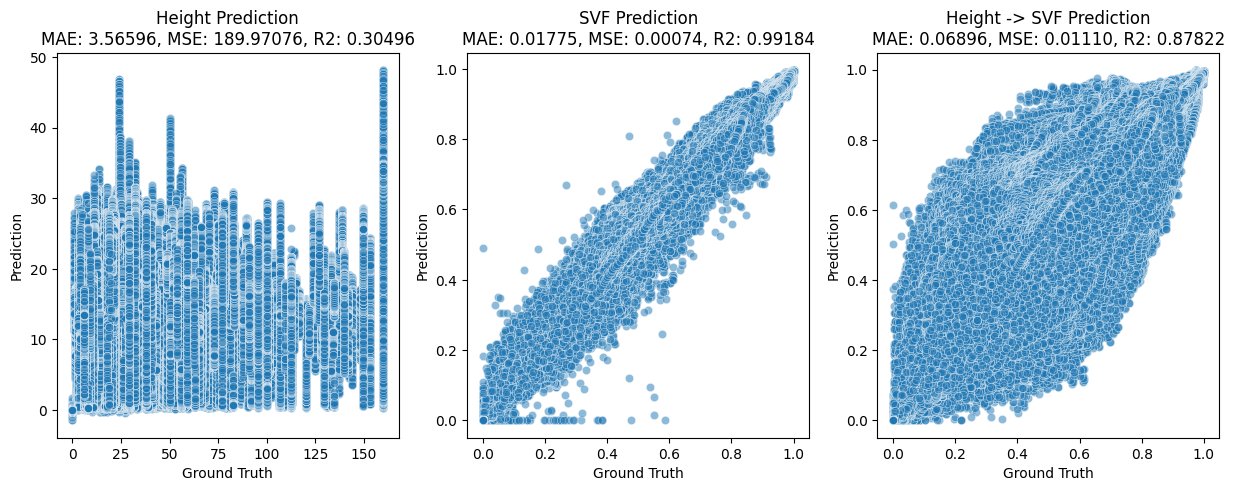

In [9]:
dh, d0, d1 = dataH, data0, data1

def plot_stats(data, ax, title=''):
    true = np.array(data[0]).reshape(-1)
    pred = np.array(data[1]).reshape(-1)
    # true = np.round(np.array(data[0]).ravel(), d)
    # pred = np.round(np.array(data[1]).ravel(), d)

    # df = pd.DataFrame({'true': true, 'pred': pred, 'v': 1 / true.shape[0]})
    # df1 = df.groupby(['true', 'pred']).sum()
    # print(df1)
    # print(df1.index)
    # plt.contourf(df1.index, df1)

    mae = mean_absolute_error(true, pred)
    mse = mean_squared_error(true, pred)
    r2 = r2_score(true, pred)
    pcc = pearsonr(true, pred)
    print(r2, pcc)
    print(f'{title}\nR2:{r2:.5f}, PearsonR:{pcc[0]:.5f}')
    print(f'{title}\nR2:{r2:.5f}, PearsonR:{pcc[0]:.5f}')
    # plt.scatter(true, pred)
    p2 = sns.scatterplot(data=pd.DataFrame({'Ground Truth': true, 'Prediction': pred}), x='Ground Truth', y='Prediction', ax=ax, alpha=0.5)
    # p2 = sns.histplot(x=true, y=pred, bins=50, pmax=0.75, pthresh=0.001, palette="Set2", ax=ax)

    p2.set_title(f'{title}\nMAE: {mae:.5f}, MSE: {mse:.5f}, R2: {r2:.5f}')

fig, ax = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(15)
plot_stats(dh, ax[0], title='Height Prediction')
plot_stats(d0, ax[1], title='SVF Prediction')
plot_stats(d1, ax[2], title='Height -> SVF Prediction')
# fig, ax = plt.subplots(1, 1)
# plot_stats(d0, ax, title='SVF Prediction')

plt.show()
